In [32]:
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector 
import numpy as np

In [ ]:
# Enetr your database details:
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='2983',
    database='ecommerce'
)
cursor = conn.cursor()

## List all unique cities where customers are located.

In [7]:
query=""" select distinct customer_city from customers"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data)
df.head(10)

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas
5,jaragua do sul
6,timoteo
7,curitiba
8,belo horizonte
9,montes claros


## Count the number of orders placed in 2017.

In [8]:
query=""" select count(order_id) from orders where year (order_purchase_timestamp) = 2017"""

cur.execute(query)
data=cur.fetchall()
print('Total order placed in 2017 are: ',data[0][0])

Total order placed in 2017 are:  135303


## Find the total sales per category.

In [12]:
query = """ select upper(products.product_category) category, round(sum(payments.payment_value),2) sales
from products join order_items on products.product_id = order_items.product_id join payments 
on payments.order_id = order_items.order_id group by category """

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['Category','Sales'])
df

,Category,Sales
0,PERFUMERY,1013477.32
1,FURNITURE DECORATION,2860352.78
2,TELEPHONY,973764.10
3,BED TABLE BATH,3425107.34
4,AUTOMOTIVE,1704588.66
...,...,...
69,CDS MUSIC DVDS,2398.86
70,LA CUISINE,5827.06
71,FASHION CHILDREN'S CLOTHING,1571.34
72,PC GAMER,4348.86


## Calculate the percentage of orders that were paid in installments.


In [15]:
query = """ select ((sum(case when payment_installments >= 1 then 1
else 0 end))/count(*))*100 from payments"""

cur.execute(query)
data = cur.fetchall()
print("The percentage of orders that were paid in installments is: ", data[0][0])

The percentage of orders that were paid in installments is:  99.9981


## Count the number of customers from each state. 


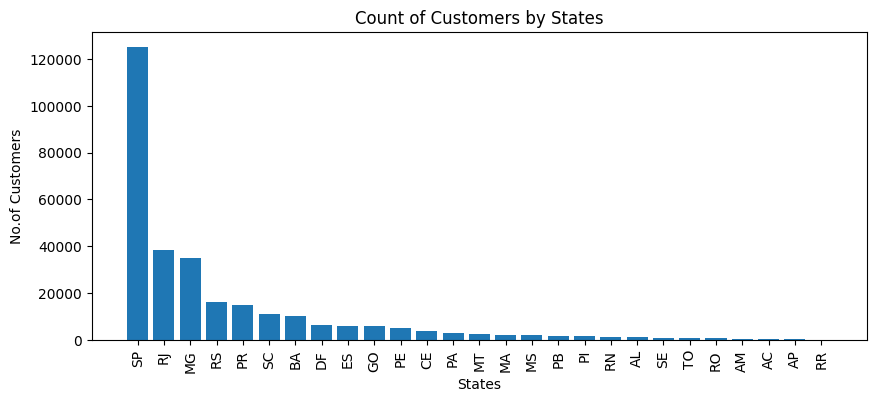

In [21]:
query= """ select customer_state,count(customer_id) from customers group by customer_state"""

cur.execute(query)
data=cur.fetchall()
df=pd.DataFrame(data,columns=['State','No.of Customers'])
df = df.sort_values(by = "No.of Customers", ascending= False)

plt.figure(figsize = (10,4))
plt.bar(df["State"], df["No.of Customers"])
plt.xticks(rotation = 90)
plt.xlabel("States")
plt.ylabel("No.of Customers")
plt.title("Count of Customers by States")
plt.show()

## Calculate the number of orders per month in 2018.

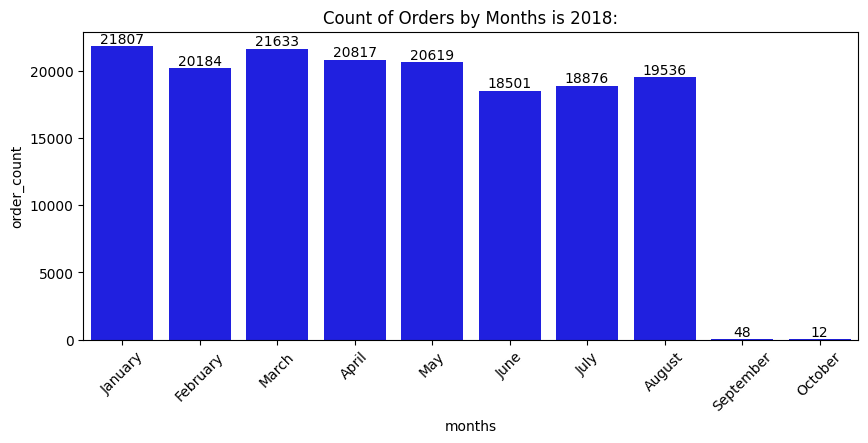

In [24]:
query= """select monthname(order_purchase_timestamp) months, count(order_id) order_count 
from orders where year(order_purchase_timestamp) = 2018 group by months"""

cur.execute(query)
data=cur.fetchall()
plt.figure(figsize = (10,4))

df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["months"],y =  df["order_count"], data = df, order = o, color = "blue")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018:")

plt.show()

## Find the average number of products per order, grouped by customer city.

In [27]:
query = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Customer City", "Average Products/Order"])
df.head(10)

,Customer City,Average Products/Order
0,padre carvalho,21.00
1,celso ramos,19.50
2,datas,18.00
3,candido godoi,18.00
4,matias olimpio,15.00
5,cidelandia,12.00
6,curralinho,12.00
7,picarra,12.00
8,morro de sao paulo,12.00
9,teixeira soares,12.00


## Calculate the percentage of total revenue contributed by each product category.

In [29]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales_percentage
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category order by sales_percentage desc"""


cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "Percentage Distribution"])
df.head(10)

,Category,Percentage Distribution
0,BED TABLE BATH,21.40
1,HEALTH BEAUTY,20.71
2,COMPUTER ACCESSORIES,19.81
3,FURNITURE DECORATION,17.87
4,WATCHES PRESENT,17.86
5,SPORT LEISURE,17.39
6,HOUSEWARES,13.68
7,AUTOMOTIVE,10.65
8,GARDEN TOOLS,10.47
9,COOL STUFF,9.74


## Identify the correlation between product price and the number of times a product has been purchased.

In [34]:
cur = db.cursor()
query = """select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("The correlation is: ", a[0][-1])

The correlation is:  -0.10631514167157562


## Calculate the total revenue generated by each seller, and rank them by revenue.


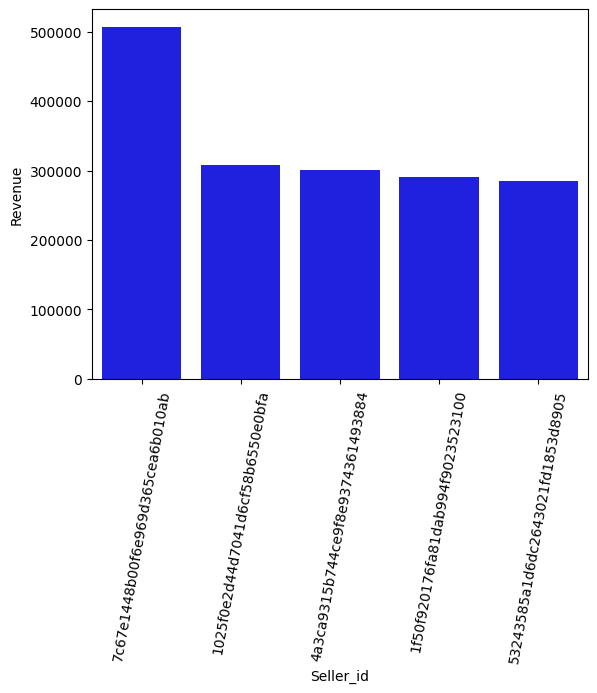

In [39]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a """

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Seller_id", "Revenue", "Rank"])
df = df.head()
sns.barplot(x = "Seller_id", y = "Revenue", data = df,color='blue')
plt.xticks(rotation = 80)
plt.show()

## Calculate the moving average of order values for each customer over their order history.

In [41]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns=["Customer_ID", "Order_Purchase_Timestamp", "Payment_Value", "Moving_Avg"])
df

,Customer_ID,Order_Purchase_Timestamp,Payment_Value,Moving_Avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
2,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
3,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
4,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
...,...,...,...,...
311653,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
311654,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.500000
311655,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001
311656,ffffe8b65bbe3087b653a978c870db99,2017-09-29 14:07:03,18.37,18.370001


## Calculate the cumulative sales per month for each year.

In [43]:
query = """select years, months , payment, sum(payment)
over(order by years, months) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years,
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns=["Year", "Month", "Monthly_Sales", "Cumulative_Sales"])
df

,Year,Month,Monthly_Sales,Cumulative_Sales
0,2016,9,756.72,756.72
1,2016,10,177271.44,178028.16
2,2016,12,58.86,178087.02
3,2017,1,415464.12,593551.14
4,2017,2,875724.03,1469275.17
5,2017,3,1349590.80,2818865.97
6,2017,4,1253364.09,4072230.06
7,2017,5,1778756.46,5850986.52
8,2017,6,1533829.14,7384815.66
9,2017,7,1777148.76,9161964.42


## Calculate the year-over-year growth rate of total sales.


In [45]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years", "yoy % Growth"])
df

,Years,yoy % Growth
0,2016,NaN
1,2017,12112.703756
2,2018,20.000924


## Calculate the retention rate of customers, defined as the percentage 
## of customers who make another purchase within 6 months of their first purchase.

In [46]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data

[(None,)]

## Identify the top 3 customers who spent the most money in each year.

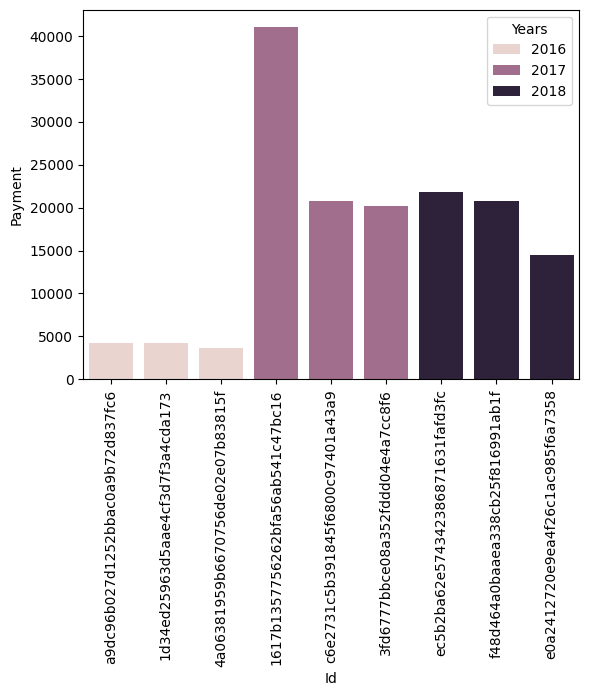

In [48]:
query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years","Id","Payment","Rank"])
sns.barplot(x = "Id", y = "Payment", data = df, hue = "Years")
plt.xticks(rotation = 90)
plt.show()